In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import matplotlib.patches as patches

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
import math
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [3]:
def sigmoid(p):
    return 1.0 / (1 + math.exp(-p * 1.0))

def overlap(x1, w1, x2, w2): #x1 ,x2 are two box center x
    left = max(x1 - w1 / 2.0, x2 - w2 / 2.0)
    right = min(x1 + w1 / 2.0, x2 + w2 / 2.0)
    return right - left

def cal_iou(box, truth):
    w = overlap(box[0], box[2], truth[0], truth[2])
    h = overlap(box[1], box[3], truth[1], truth[3])
    if w < 0 or h < 0:
        return 0
    inter_area = w * h
    union_area = box[2] * box[3] + truth[2] * truth[3] - inter_area
    return inter_area * 1.0 / union_area

def apply_nms(boxes, thres):
    sorted_boxes = sorted(boxes,key=lambda d: d[7])[::-1]
    p = dict()
    for i in range(len(sorted_boxes)):
        if i in p:
            continue
        
        truth =  sorted_boxes[i]
        for j in range(i+1, len(sorted_boxes)):
            if j in p:
                continue
            box = sorted_boxes[j]
            iou = cal_iou(box, truth)
            if iou >= thres:
                p[j] = 1
    
    res = list()
    for i in range(len(sorted_boxes)):
        if i not in p:
            res.append(sorted_boxes[i])
    return res

def show_boxes(boxes):
    label_name = {0: "bg", 1: "aeroplane", 2: "bicycle", 3: "bird", 4: "boat", 5: "bottle", 6: "bus", 7: "car", 
              8: "cat", 9: "chair", 10: "cow", 11: "diningtable", 12: "dog", 13: "horse", 14: "motorbike", 
              15: "person", 16: "pottedplant", 17: "sheep", 18: "sofa", 19: "train", 20: "tvmonitor"}
    w = image.shape[1]
    h = image.shape[0]

    plt.imshow(image)
    currentAxis = plt.gca()
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    
    for box in boxes:
        
        x_min = int(round((box[0]-box[2]/2.0) * w))
        x_max = int(round((box[0]+box[2]/2.0) * w))
        y_min = int(round((box[1]-box[3]/2.0) * h))
        y_max = int(round((box[1]+box[3]/2.0) * h))
        
        if x_min < 0:
            x_min = 0
        if x_max > w:
            x_max = w
        if y_min < 0:
            y_min = 0
        if y_max > h:
            y_max = h
        
        
        display_txt = '{:0.2f}, {}'.format(box[7], label_name[box[4]])
        coords = (x_min, y_min), x_max-x_min+1, y_max-y_min+1
        color = colors[box[4]]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(x_min, y_min, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    plt.show()

def write_txt():
    w = image.shape[1]
    h = image.shape[0]

    file_name = "000012"
    res_name = "com4_det_test_";
    for box in boxes:
        name = res_name + label_name[box[4]]
        fid = open(name+".txt", 'a')
        fid.write(file_name)
        fid.write(' ')
        fid.write(str(box[5]*box[6]))
        fid.write(' ')
        fid.write(str((box[0]-box[2]/2.0) * w))
        fid.write(' ')
        fid.write(str((box[0]+box[2]/2.0) * w))
        fid.write(' ')
        fid.write(str((box[1]-box[3]/2.0) * h))
        fid.write(' ')
        fid.write(str((box[1]+box[3]/2.0) * h))
        fid.write('\n')
        fid.close()

In [4]:
caffe.set_mode_cpu()

model_def = './darknet_v3/gnet_region_test_darknet_deploy.prototxt'
model_weights = './darknet_v3/gnet_yolo_region_darknet_v3_pretrain_rectify_iter_200000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
#mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
#mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
#print 'mean-subtracted values:', zip('BGR', mu)

mu = np.array([105, 117, 123])
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          416, 416)  # image size is 227x227

In [6]:
image = caffe.io.load_image(caffe_root + 'examples/eval_detection_yolo_v2/data/000004.jpg')
transformed_image = transformer.preprocess('data', image)

In [7]:
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

res = output['conv_reg'][0]  # the output probability vector for the first image in the batch

swap = np.zeros((13*13,5,25))

#change
index = 0
for h in range(13):
    for w in range(13):
        for c in range(125):
            swap[h*13+w][c/25][c%25]  = res[c][h][w]

biases = [1.08,1.19,3.42,4.41,6.63,11.38,9.42,5.11,16.62,10.52]

boxes = list()
for h in range(13):
    for w in range(13):
        for n in range(5):
            box = list();
            cls = list();
            s = 0;
            x = (w + sigmoid(swap[h*13+w][n][0])) / 13.0; #center x
            y = (h + sigmoid(swap[h*13+w][n][1])) / 13.0; #center y
            ww = (math.exp(swap[h*13+w][n][2])*biases[2*n]) / 13.0; #w
            hh = (math.exp(swap[h*13+w][n][3])*biases[2*n+1]) / 13.0; #h
            obj_score = sigmoid(swap[h*13+w][n][4]);
            for p in range(20):
                cls.append(swap[h*13+w][n][5+p]);
            
            large = max(cls);
            for i in range(len(cls)):
                cls[i] = math.exp(cls[i] - large);
            
            s = sum(cls);
            for i in range(len(cls)):
                cls[i] = cls[i] * 1.0 / s;
                
            box.append(x); #0
            box.append(y); #1
            box.append(ww); #2
            box.append(hh); #3
            box.append(cls.index(max(cls))+1) #4
            box.append(obj_score); #5
            box.append(max(cls)); #6
            box.append(obj_score * max(cls))
            
            if box[5] * box[6] > 0.5:
                boxes.append(box);

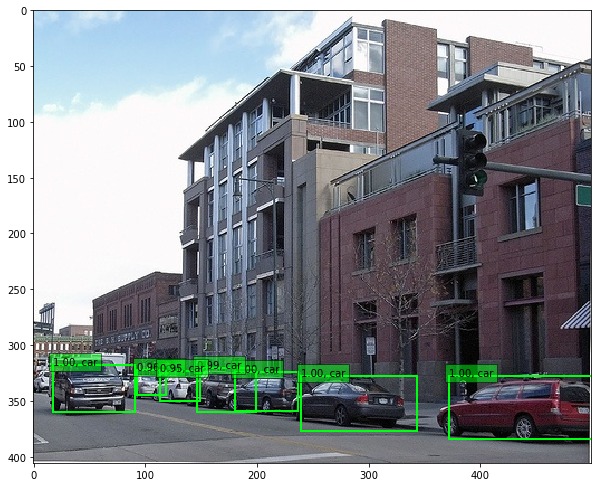

In [8]:
res = apply_nms(boxes, 0.6)
show_boxes(res)